In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd 'drive/My Drive/UrbanSound8K'

/content/drive/My Drive/UrbanSound8K


In [3]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential, load_model
from keras.layers import LSTM, Activation
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [4]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [5]:
parent_dir = 'audio'

In [6]:
import pickle
def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    for l, sub_dir in enumerate(sub_dirs):
        mfccs = []
        log_specgrams = []
        labels = []
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            #UrbanSound8K/audio/fold*/*.wav
            label = fn.split('/')[-1].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
              if len(sound_clip[start:end]) == window_size:
                signal = sound_clip[start:end]
                #melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                #logspec = librosa.amplitude_to_db(melspec)
                #logspec = logspec.T.flatten()[:, np.newaxis].T
                #log_specgrams.append(logspec)
                mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                mfccs.append(mfcc)
                labels.append(label)         
        #feature = np.hstack(mfcc, logspec)
        feature = np.asarray(mfccs).reshape(len(mfccs),frames,bands)
        filename = 'mfcc_features_{}.pk'.format(sub_dir)
        #filename = 'melspec_mfcc_features_{}.pk'.format(sub_dir)
        f=open(filename,'wb')
        pickle.dump(feature,f)
        f.close()
        filename = 'mfcc_labels_{}.pk'.format(sub_dir)
        f=open(filename,'wb')
        pickle.dump(labels,f)
        f.close()
        print('finish loading {}, shape : {}'.format(sub_dir,feature.shape))
    #features = np.hstack((mfccs, log_specgrams))
    #features = np.asarray(features).reshape(len(features),frames,bands)

In [10]:
sub_dirs = ['fold{}'.format(i) for i in range(1,11)]
extract_features(parent_dir,sub_dirs)

finish loading fold1, shape : (5446, 41, 20)
finish loading fold2, shape : (5388, 41, 20)
finish loading fold3, shape : (5852, 41, 20)
finish loading fold4, shape : (6048, 41, 20)
finish loading fold5, shape : (5689, 41, 20)
finish loading fold6, shape : (5080, 41, 20)
finish loading fold7, shape : (5277, 41, 20)
finish loading fold8, shape : (4942, 41, 20)
finish loading fold9, shape : (5118, 41, 20)
finish loading fold10, shape : (5218, 41, 20)


In [11]:
def one_hot_encode(labels):
    n_labels = len(labels)
    labels = np.asarray(labels, dtype=np.int)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [12]:
import pickle
tr_features = []
tr_labels = []
ts_features = []
ts_labels = []

for sub_dir in ['fold{}'.format(i) for i in range(1,7)] :
  feature_file = 'mfcc_features_{}.pk'.format(sub_dir)
  label_file = 'mfcc_labels_{}.pk'.format(sub_dir)
  f1=open(feature_file,'rb')
  f2=open(label_file,'rb')
  tmp_features = pickle.load(f1)
  tmp_labels = pickle.load(f2)
  f1.close()
  f2.close()
  tr_features.extend(tmp_features)
  tr_labels.extend(tmp_labels)
tr_features=np.asarray(tr_features)
tr_labels=one_hot_encode(tr_labels)

for sub_dir in ['fold{}'.format(i) for i in range(7,10)] :
  feature_file = 'mfcc_features_{}.pk'.format(sub_dir)
  label_file = 'mfcc_labels_{}.pk'.format(sub_dir)
  f1=open(feature_file,'rb')
  f2=open(label_file,'rb')
  tmp_features = pickle.load(f1)
  tmp_labels = pickle.load(f2)
  f1.close()
  f2.close()
  ts_features.extend(tmp_features)
  ts_labels.extend(tmp_labels)
ts_features=np.asarray(ts_features)
ts_labels=one_hot_encode(ts_labels)

sub_dir = 'fold10' #10 fold for test data
feature_file = 'mfcc_features_{}.pk'.format(sub_dir)
label_file = 'mfcc_labels_{}.pk'.format(sub_dir)
f1=open(feature_file,'rb')
f2=open(label_file,'rb')
test_features = pickle.load(f1)
test_labels = pickle.load(f2)
f1.close()
f2.close()
test_features = np.asarray(test_features)
test_labels = one_hot_encode(test_labels)

In [13]:
print(tr_features.shape, tr_labels.shape)
print(ts_features.shape, ts_labels.shape)
print(test_features.shape, test_labels.shape)

(33503, 41, 20) (33503, 10)
(15337, 41, 20) (15337, 10)
(5218, 41, 20) (5218, 10)


In [14]:
# Training Parameters
epochs = 1000
batch_size = 2**10

# Network Parameters
n_input = 20
n_steps = 41
n_hidden = 200
n_classes = 10
use_dropout = False

In [15]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(n_steps,n_input), return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
if use_dropout :
  model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

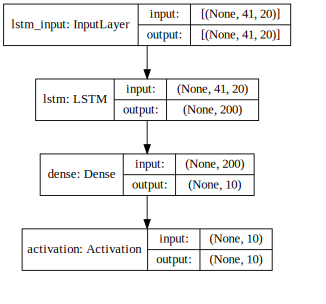

In [16]:
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               176800    
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 178,810
Trainable params: 178,810
Non-trainable params: 0
_________________________________________________________________


In [18]:
checkpointer = ModelCheckpoint(filepath='2LSTM_hidden20-{epoch:02d}.hdf5', verbose=1)

In [19]:
model.fit(tr_features,tr_labels,epochs=epochs,batch_size=batch_size,validation_data=(ts_features,ts_labels), callbacks=[checkpointer])

Epoch 1/1000
33/33 [==============================] - 9s 172ms/step - loss: 2.0764 - categorical_accuracy: 0.2541 - val_loss: 1.7349 - val_categorical_accuracy: 0.3892

Epoch 00001: saving model to 2LSTM_hidden20-01.hdf5
Epoch 2/1000
33/33 [==============================] - 5s 147ms/step - loss: 1.4578 - categorical_accuracy: 0.5155 - val_loss: 1.6022 - val_categorical_accuracy: 0.4336

Epoch 00002: saving model to 2LSTM_hidden20-02.hdf5
Epoch 3/1000
33/33 [==============================] - 5s 145ms/step - loss: 1.1635 - categorical_accuracy: 0.6208 - val_loss: 1.5777 - val_categorical_accuracy: 0.4738

Epoch 00003: saving model to 2LSTM_hidden20-03.hdf5
Epoch 4/1000
33/33 [==============================] - 5s 163ms/step - loss: 0.9566 - categorical_accuracy: 0.6912 - val_loss: 1.5832 - val_categorical_accuracy: 0.4935

Epoch 00004: saving model to 2LSTM_hidden20-04.hdf5
Epoch 5/1000
33/33 [==============================] - 5s 159ms/step - loss: 0.8028 - categorical_accuracy: 0.7459 - 

In [20]:
model.save('2LSTM_hidden20.hdf5')

In [21]:
model = load_model('2LSTM_hidden20-01.hdf5')

In [22]:
tr_accuracy = []
test_accuracy = []
for epoch in np.arange(1,1000,100):
  model = load_model('2LSTM_hidden20-{:02d}.hdf5'.format(epoch))
  # Evaluating the model on the training and testing set
  score = model.evaluate(tr_features, tr_labels, verbose=1)
  print("Training Accuracy: ", score[1])
  tr_accuracy.append(score[1])
  score = model.evaluate(test_features, test_labels, verbose=1)
  print("Testing Accuracy: ", score[1])
  test_accuracy.append(score[1])

1047/1047 [==============================] - 14s 13ms/step - loss: 1.5227 - categorical_accuracy: 0.5075
Training Accuracy:  0.5074769258499146
164/164 [==============================] - 2s 12ms/step - loss: 1.7477 - categorical_accuracy: 0.3917
Testing Accuracy:  0.3917209804058075
1047/1047 [==============================] - 14s 13ms/step - loss: 0.0368 - categorical_accuracy: 0.9874
Training Accuracy:  0.9873742461204529
164/164 [==============================] - 2s 13ms/step - loss: 3.0921 - categorical_accuracy: 0.5408
Testing Accuracy:  0.5408202409744263
1047/1047 [==============================] - 14s 13ms/step - loss: 0.0204 - categorical_accuracy: 0.9933
Training Accuracy:  0.9932543635368347
164/164 [==============================] - 2s 12ms/step - loss: 3.0204 - categorical_accuracy: 0.5546
Testing Accuracy:  0.5546186566352844
1047/1047 [==============================] - 13s 12ms/step - loss: 0.0169 - categorical_accuracy: 0.9942
Training Accuracy:  0.9942094683647156
164/

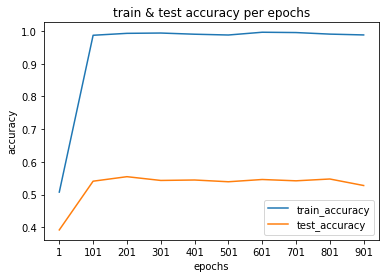

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

result = pd.DataFrame({'train_accuracy': tr_accuracy, 'test_accuracy' : test_accuracy})
result.plot()
plt.xticks(np.arange(10),np.arange(1,1000,100))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epochs')
plt.legend(loc='best')
plt.show()
